# ReBar DSC: object detection and count
This notebook shows the potential of a RetinaNet on the [https://github.com/Armin1337/RebarDSC](RebarDSC dataset).

RebarDSC is an industrial rebar collection scene - fully annotated with bounding boxes. A few notes on the dataset:
- a train-test split is provided. The train set contains 1250 annotated images, compared to 1000 images in the test set
- they all contain different resolution. A FCN is required to perform the segmentation and must address this

## Candidate solutions
Multiple solutions can address this problem. One can tackle it through computer vision segmentation approaches (e.g.: watershed), although, the fact that bounding boxes are also provided
allow for a quick implementation of a supervised learning model. Another candidate solution could be to make use of a VFM (Visual Foundation Model). These types of model
tend to segment every object in the images, and this may not fit well RebarDSC, as we can expect that objects would be oversegmented, requiring a posteriori filtering based on the morphology.

In this notebook, we show the potential of another approach, i.e., a supervised learning model such as RetinaNet, that can be easily trained given the amount of annotations available
(assuming the availability of enough resources).

In [1]:
import sys

import numpy as np

from model.layers.decode_predictions import DecodePredictions
from model.retinanet import RetinaNet

sys.path.insert(0, '../model')

from utils.utils import *
from utils.inference import *
import pandas as pd
import seaborn as sns

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

%reload_ext autoreload
%autoreload 2

## Model initialization
Our implementation of RetinaNet through Keras can be summarized as follows:
- a FPN (Feature Pyramid Network) is used to extract features from a backbone
- ResNet50 is used as a backbone for the FPN
- on top of this, two heads - associated to the class and to the bounding box - allow to use the model for a generic instance segmentation task. Keep in mind that in our case, there is a single class.

RetinaNet returns the output from the head layers (bounding boxes and classes). A decoder is used to transform bounding boxes from XYWH to XYXY format.
The model has been trained on 3 epochs for lack of resources. Although, results are promising and can be improved through 1) augmentation, 2) higher resources both in terms of hardware and time and 3) through the improvement of the model (FPN can be improved, and other backbones can provide better results).

Currently, only a random horizontal flip is performed - which is not enough to improve generalization. Instead, additional transformations (including rotation or shear transformations) would support the training of a much more accurate model.

In [2]:
num_classes = 1
resnet50_backbone = get_backbone()
base_dir = get_dataset_path()

retina_net = RetinaNet(num_classes, resnet50_backbone)
weight_epoch = 3

weights_dir = "../training/retinanet-v1"

weights_path = os.path.join(
            weights_dir,
            f"weights_epoch_{weight_epoch}",
        )
retina_net.load_weights(weights_path)

model = inference_model(model=retina_net, decoder= DecodePredictions(confidence_threshold=.35, max_detections=1000, max_detections_per_class=1000, nms_iou_threshold=.6), weights_dir=weights_dir, weight_epoch=weight_epoch)

C:\Users\FKRASNIQI\AppData\Local\anaconda3\envs\cellai\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


## Dataset initialization
The dataset has been put into TF records, which provides high efficiency in terms of IO, storage, memory usage. See the conversion in TODO add reference.

In [3]:
ds = get_test_dataset(base_dir=base_dir, test_tf_record="test_v3.tfrecord")

annotations_path = os.path.join(base_dir, "annotations")
path_test_csv = os.path.join(annotations_path, "test_ds.csv")

df_test = pd.read_csv(path_test_csv)
df_test = df_test[['filename', 'bbox-0']].groupby('filename').count().rename(columns={"bbox-0": 'count'}).reset_index()

## Example of a prediction
An image with the bounding boxes retrieved by the model is shown in this block. The model outputs also the confidence (min. set to 0.35), but it is not shown here to avoid confusion with the bounding boxes, as the objects are clustered close one to the other.

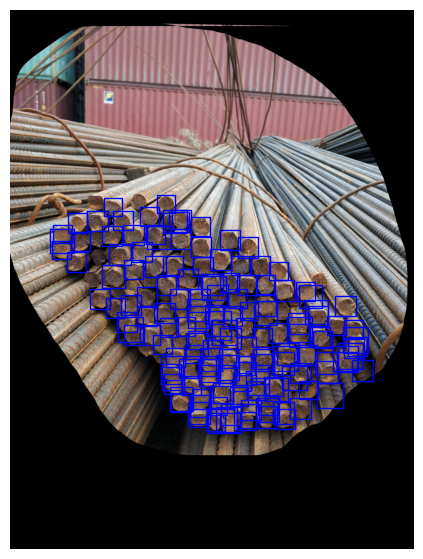

In [4]:
index_segmentation = 1
ds_sample = ds.skip(index_segmentation)

show_sample(model=model, sample=list(ds_sample.take(1))[0])

## Model execution
We initialize a new dataframe containing the object count from the test set and from the model output. We also compute the Absolute Percentage Error to compare the model count against the ground truth.

In [5]:
n_to_take = df_test.shape[0]
num_objects = compute_num_objects(
    model=model,
    ds=ds,
    n_to_take=n_to_take,
)

df_g = pd.read_csv(path_test_csv).groupby('filename')

filenames = [f for f, _ in df_g][:n_to_take]

df_test_model = pd.DataFrame({'filename': filenames, 'model_count': num_objects})
df_test_model = pd.merge(df_test, df_test_model, on='filename')
df_test_model['ae'] = df_test_model.apply(lambda x: abs(x['model_count'] - x['count']), axis=1)
df_test_model['ape'] = df_test_model.apply(lambda x: x['ae'] / x['count'], axis=1) * 100

### Scatterplot ground truth count vs model count
To show the model performance on the test set, we scatterplot the model count (Y-axis) against the ground truth (X-axis). The green line represents the identity function.

A positive trend is clearly visible, although, in several cases the count is highly wrong. Improvement can be achieved through ideas defined above (augmentation, more training, model improvement).

Text(0.5, 1.0, 'Model Count vs Ground Truth')

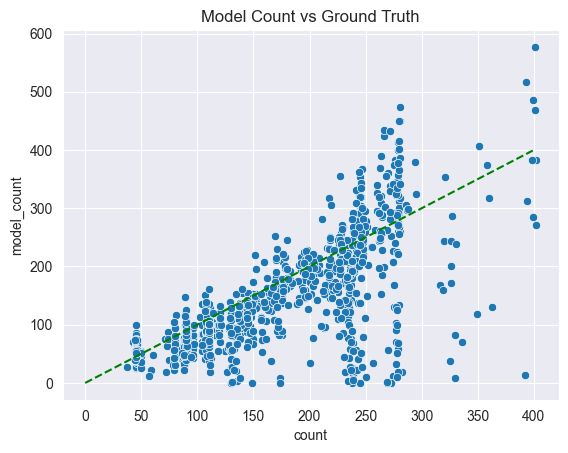

In [6]:
ax = plt.subplot()

sns.scatterplot(data=df_test_model, x='count', y='model_count', ax=ax)

x_vals = range(400)
ax.plot(x_vals, x_vals, '--', color='green', )

ax.set_title("Model Count vs Ground Truth")

## APE histogram
We also plot the absolute percentage error of the count. Median is close to 20%. The measurement is highly biased by those cases where the count is highly wrong.

Text(0.5, 1.0, 'Absolute Percentage Error [%]')

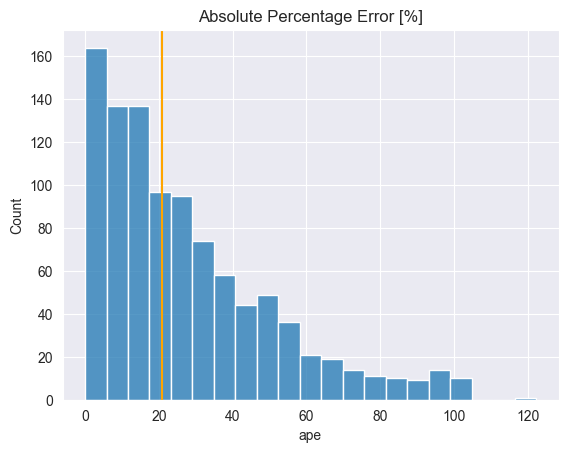

In [7]:
median = np.median(df_test_model['ape'])

ax = plt.subplot()
ax = sns.histplot(data=df_test_model, x='ape', ax=ax)

ax.axvline(median, color='orange')
ax.set_title("Absolute Percentage Error [%]")

## Worst and best case results
To understand what are the motivations behind poor accuracy on some images, we show the best and worst case scenario. From the images shown below, it seems like size, intensity, background, object density are the main factors behind bad accuracy.

In [8]:
worst_images = df_test_model.sort_values('ae', ascending=False).iloc[:2]['filename']
best_images = df_test_model.sort_values('ae', ascending=True).iloc[:2]['filename']

### Worst images

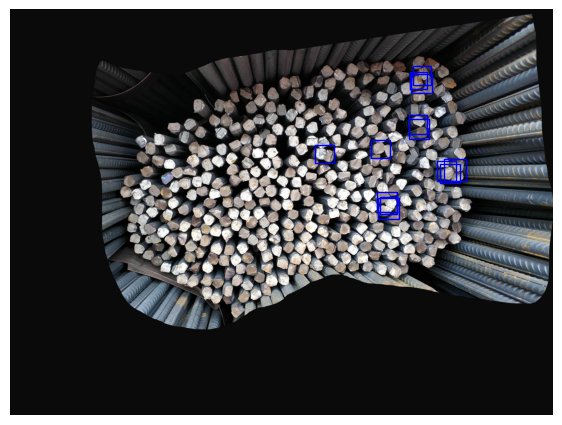

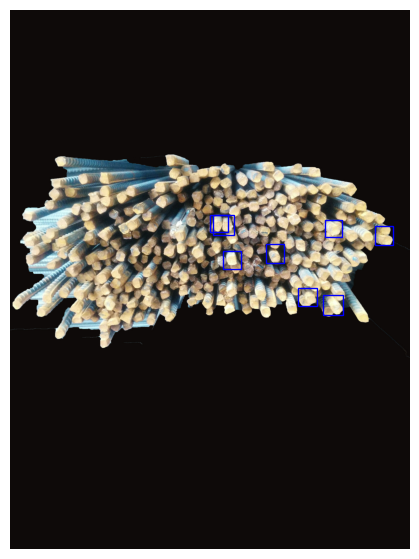

In [9]:
for worst_image in worst_images:
    idx_image = df_test[df_test['filename'] == worst_image].index[0]
    ds_sample = ds.skip(idx_image)
    show_sample(model=model, sample=list(ds_sample.take(1))[0])

### Best images

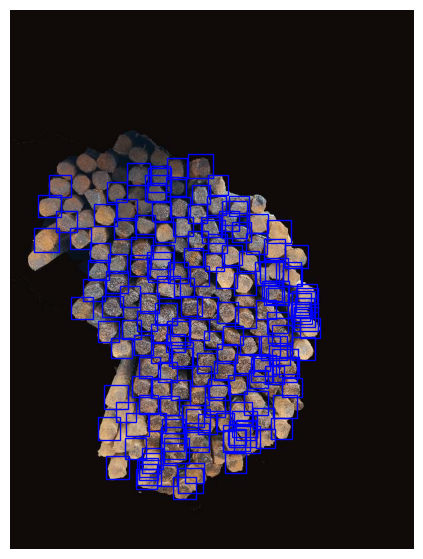

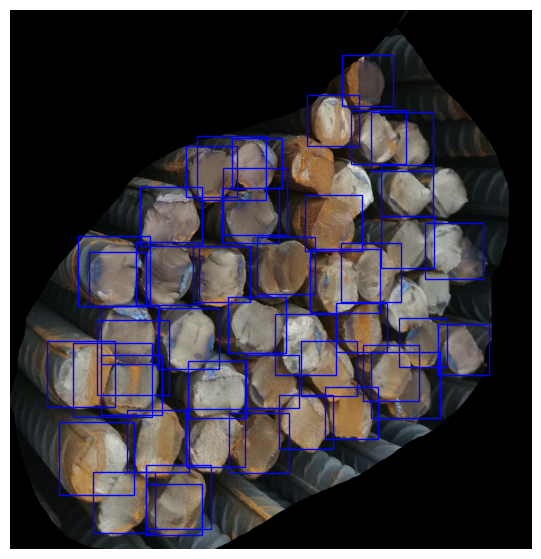

In [10]:
for best_image in best_images:
    idx_image = df_test[df_test['filename'] == best_image].index[0]
    ds_sample = ds.skip(idx_image)
    show_sample(model=model, sample=list(ds_sample.take(1))[0])

## Conclusion
A RetinaNet has been trained on the RebarDSC dataset, providing a median Absolute Percentage Error of 20%. The validation is focused on showing the error in the object count, although, validating the instance segmentation is ideal. Example metrics could be Average Precision (including the number of matching objects) and Mean IoU.

To improve the performance, one could

- add augmentation (either through Albumentation or custom tensorflow methods) involving affine transformations, rotation, resizing;
- test more backbones;
- improve Feature Network.

Testing out SAM model with morphology analysis to remove duplicates can also be a solution for the object count.